In [1]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

CONSTANTS

In [2]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

## 1. Set GPU Memory Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Load in Images

### 2.1 Load in a single image and its mask

In [4]:
IMAGES_PATH = os.path.join("data", "Images")
MASKS_PATH = os.path.join("data", "Masks")

In [5]:
image_file_paths = glob.glob(IMAGES_PATH+"\\*.tif")
mask_file_paths = glob.glob(MASKS_PATH+"\\*.tif")

### 2.2 Visualize Single Image and Mask

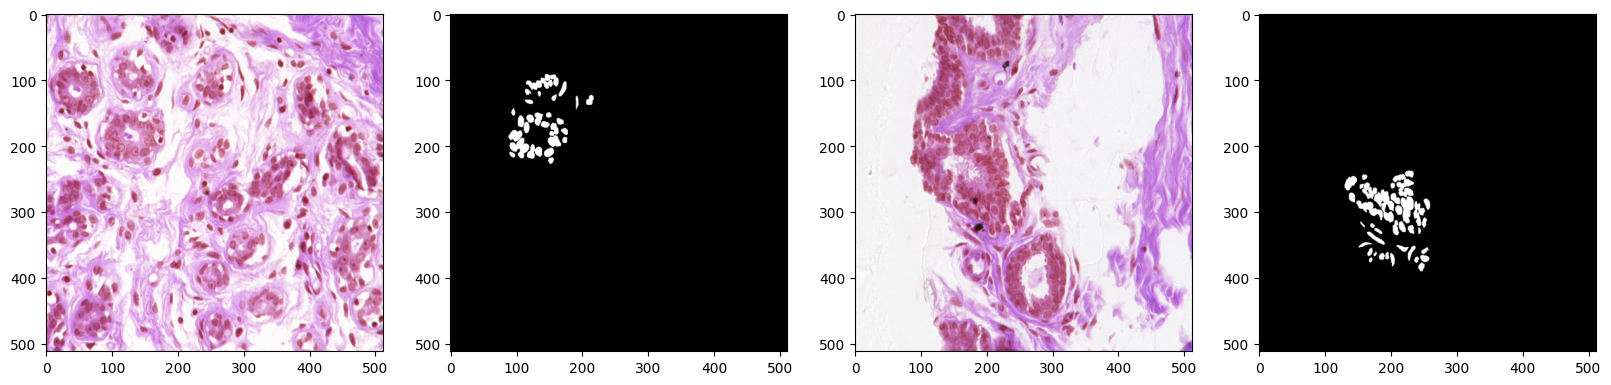

In [6]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for i in range(0, 3, 2):
    example_image = cv2.imread(image_file_paths[i])
    example_image = cv2.resize(example_image, (IMG_HEIGHT, IMG_WIDTH))
    example_mask = cv2.imread(mask_file_paths[i])
    example_mask = cv2.resize(example_mask, (IMG_HEIGHT, IMG_WIDTH))
    ax[i].imshow(example_image)
    ax[i+1].imshow(example_mask)

### 2.3 Preprocess Images

In [7]:
def load_images(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image/255


In [8]:
images = np.array([load_images(img_path) for img_path in image_file_paths])
masks = np.array([load_images(mask_path) for mask_path in mask_file_paths])

### 2.4 Split Data into Train and Test

In [9]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, train_size=0.70, random_state=42)

In [10]:
train_images.shape, test_images.shape, train_masks.shape, test_masks.shape

((40, 512, 512, 3), (18, 512, 512, 3), (40, 512, 512, 3), (18, 512, 512, 3))

### 2.5 Create Training Tensorflow Datasets

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(8)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
train_ds = train_dataset.as_numpy_iterator()

### 2.6 Visualizing Training Images and Masks

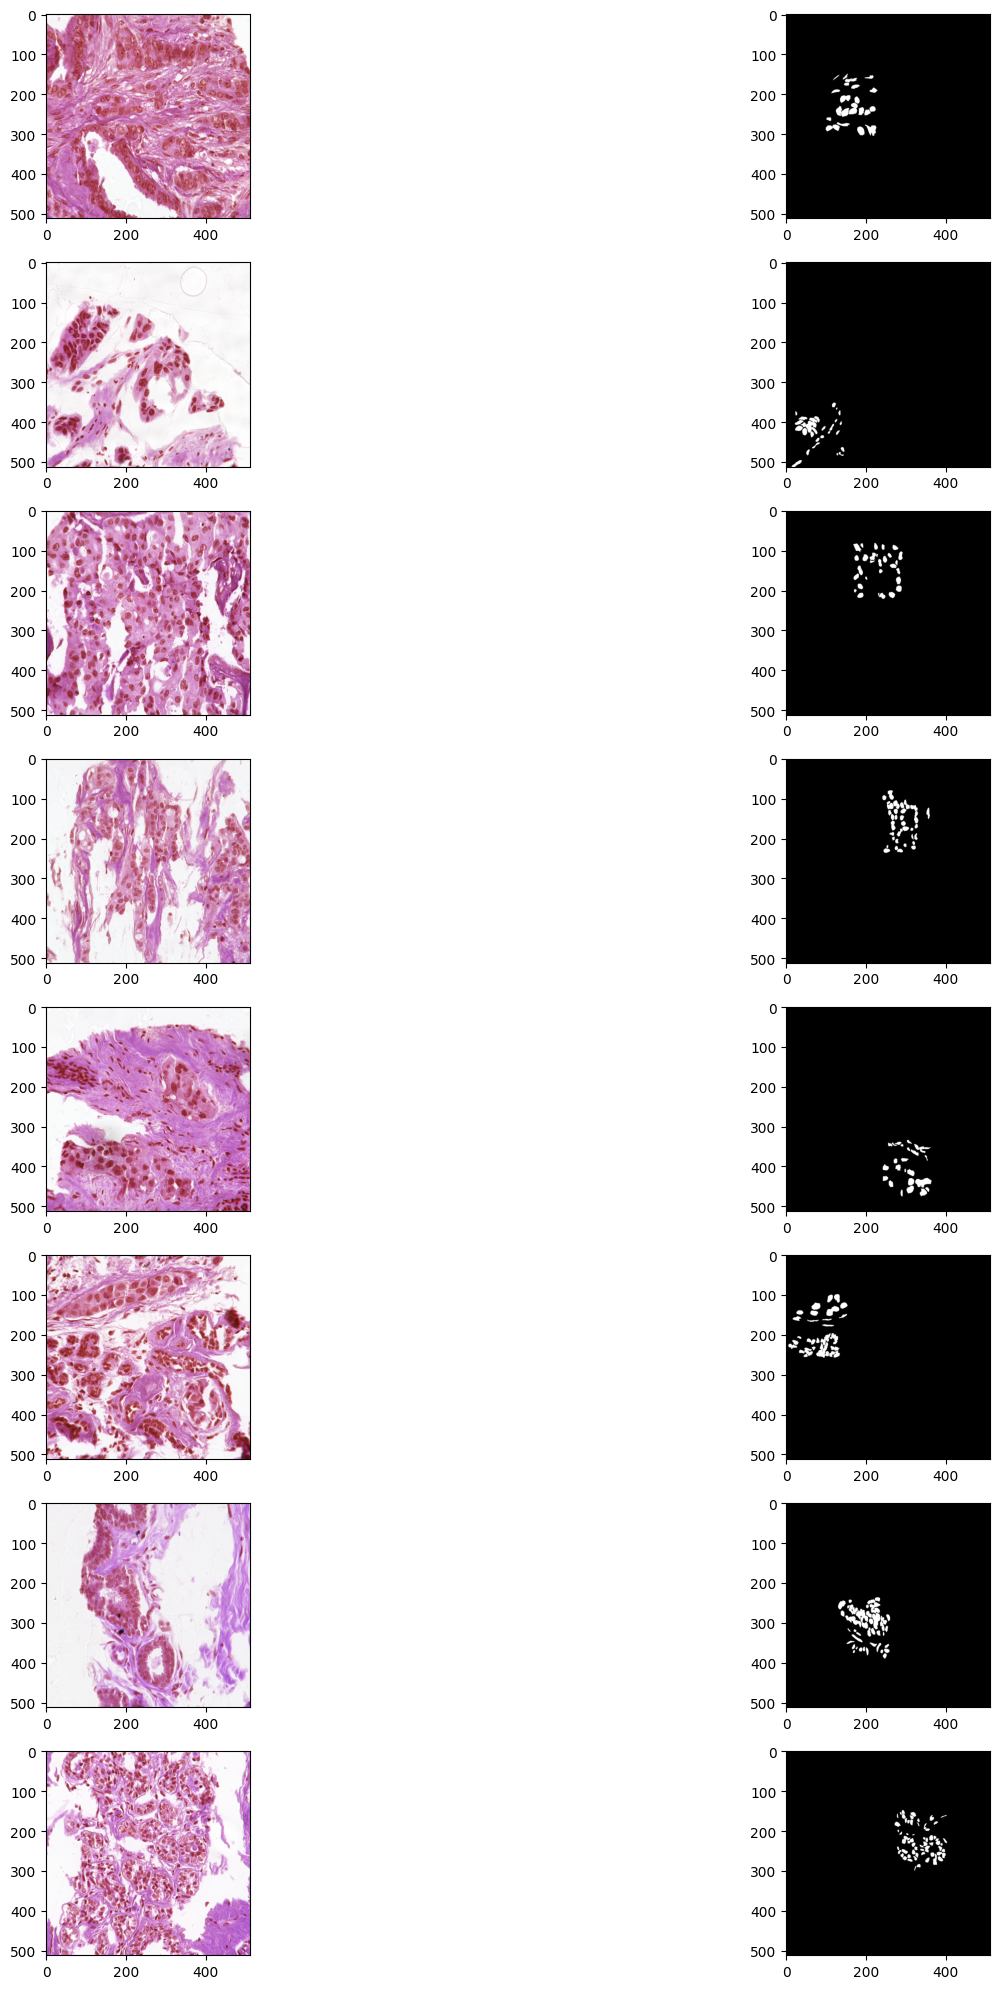

In [13]:
train_batch = train_ds.next()
fig, ax = plt.subplots(ncols = 2, nrows= 8, figsize = (20,20))
for i in range(8):
    img = train_batch[0][i]
    mask = train_batch[1][i]
    ax[i,0].imshow(img)
    ax[i,1].imshow(mask)
plt.tight_layout()
plt.show()

## 3. Creating the Model

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model

### 3.1 Creating the U-Net

In [35]:
def build_unet():
    input_layer = Input(shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Encoder

    # Convolutional Block 1
    e1 = Conv2D(16, (3,3), activation = "relu", padding = "same") (input_layer)
    e1 = Conv2D(16, (3,3), activation = "relu", padding = "same") (e1)
    p1 = MaxPooling2D((2,2)) (e1)

    # Convolutional Block 2
    e2 = Conv2D(32, (3,3), activation = "relu", padding = "same") (p1)
    e2 = Conv2D(32, (3,3), activation = "relu", padding = "same") (e2)
    p2 = MaxPooling2D((2,2)) (e2)

    # Convolutional Block 3
    e3 = Conv2D(64, (3,3), activation = "relu", padding = "same") (p2)
    e3 = Conv2D(64, (3,3), activation = "relu", padding = "same") (e3)
    p3 = MaxPooling2D((2,2)) (e3)

    # Convolutional Block 4
    e4 = Conv2D(128, (3,3), activation = "relu", padding = "same") (p3)
    e4 = Conv2D(128, (3,3), activation = "relu", padding = "same") (e4)
    p4 = MaxPooling2D((2,2)) (e4)

    # Convolutional Block 5
    e5 = Conv2D(256, (3,3), activation = "relu", padding = "same") (p4)
    encoder_output = Conv2D(256, (3,3), activation = "relu", padding = "same") (e5)

    # Decoder

    # Convolutional Block 6
    d6 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same") (encoder_output)
    d6 = concatenate([d6, e4])
    d6 = Conv2D(128, (3,3), activation = "relu", padding = "same") (d6)
    d6 = Conv2D(128, (3,3), activation = "relu", padding = "same") (d6)

    # Convolutional Block 7
    d7 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same") (d6)
    d7 = concatenate([d7, e3])
    d7 = Conv2D(64, (3,3), activation = "relu", padding = "same") (d7)
    d7 = Conv2D(64, (3,3), activation = "relu", padding = "same") (d7)

    # Convolutional Block 8
    d8 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same") (d7)
    d8 = concatenate([d8, e2])
    d8 = Conv2D(32, (3,3), activation = "relu", padding = "same") (d8)
    d8 = Conv2D(32, (3,3), activation = "relu", padding = "same") (d8)

    # Convolutional Block 9
    d9 = Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same") (d8)
    d9 = concatenate([d9, e1], axis = 3)
    d9 = Conv2D(16, (3,3), activation = "relu", padding = "same") (d9)
    d9 = Conv2D(16, (3,3), activation = "relu", padding = "same") (d9)

    # Output Layer
    unet_output = Conv2D(1, (1,1), activation = "sigmoid") (d9)

    unet_model = Model(input_layer, unet_output)

    return unet_model


In [36]:
unet = build_unet()

In [37]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_83 (Conv2D)             (None, 512, 512, 16  448         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_83[0][0]']              
                                )                                                           

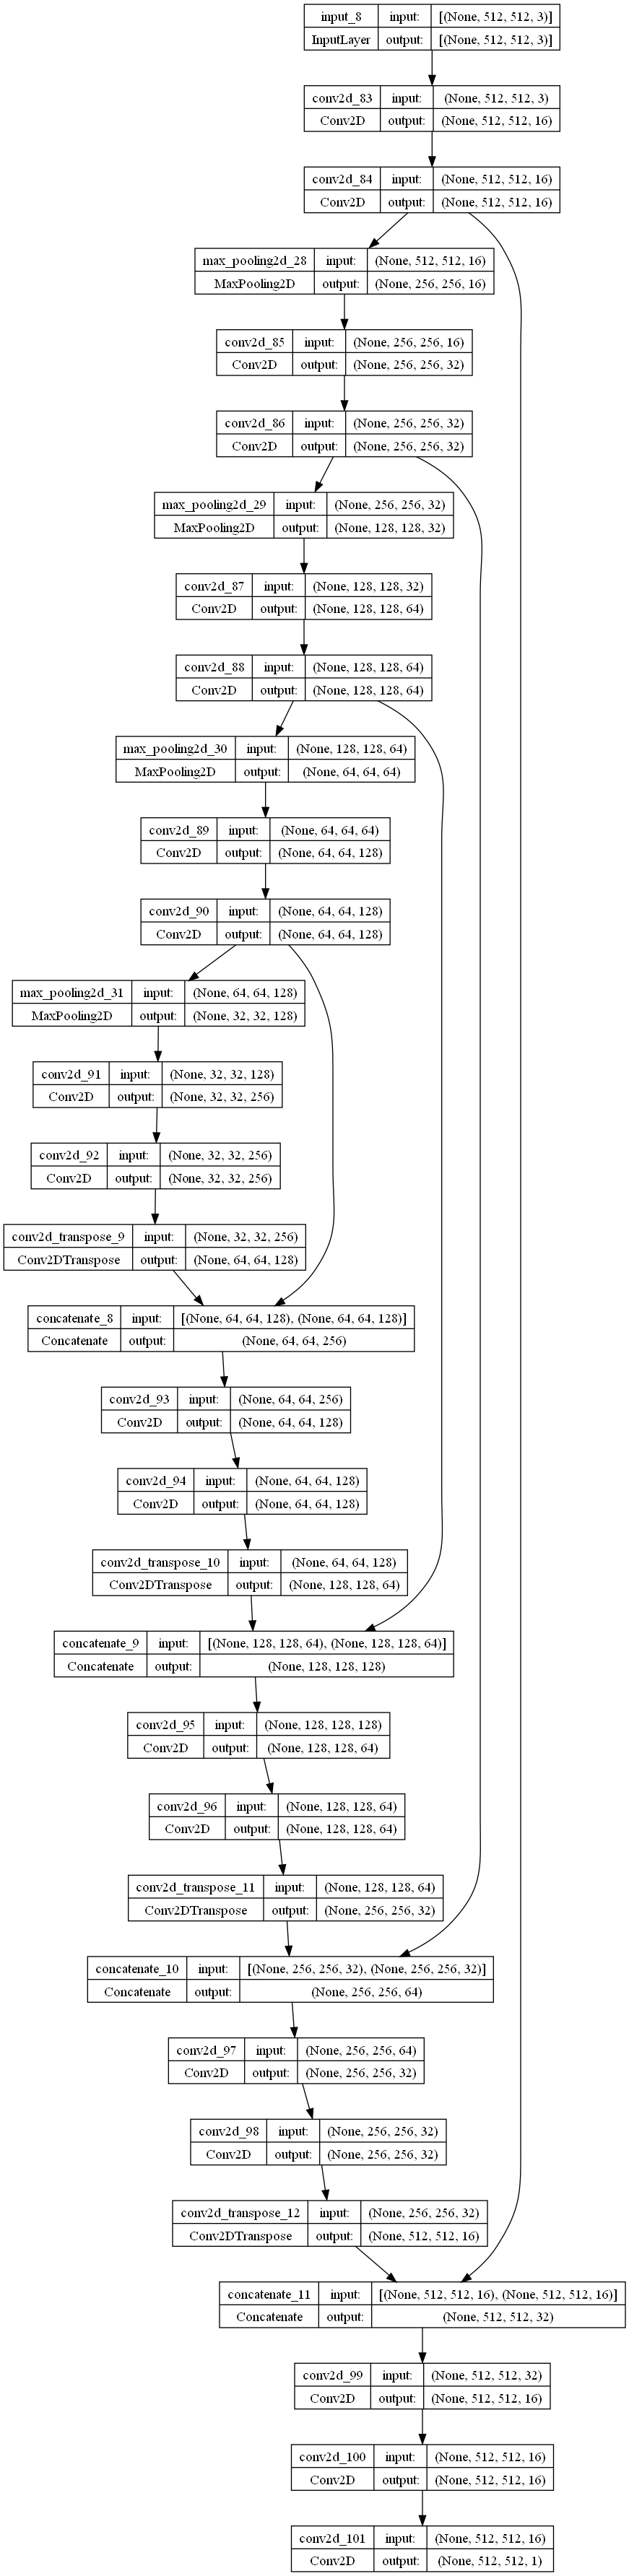

In [38]:
tf.keras.utils.plot_model(unet, to_file="unet_model_1.png", show_shapes=True)